In [1]:
# Master jupyter notebook for Case Study

In [2]:
# importing libraries
import pandas as pd
import sqlite3
from sklearn.preprocessing import LabelEncoder
import datetime
from forex_python.converter import CurrencyRates
from forex_python.converter import RatesNotAvailableError
import plotly.express as px
import nbformat
import matplotlib

In [3]:
# extracting tables from database
def list_tables(database_file):
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    cursor.execute("""select name from sqlite_master where type = 'table';
                    """)
                    
    tables = cursor.fetchall()
    cursor.close()
    connection.close()
    table_names = [table[0] for table in tables]
    return table_names

# saving tables as dataframes
connection = sqlite3.connect('data.db')
query = """select *
        from client as cl;
        """
client = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from client_products as cl;
        """
client_products = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from balances as cl;
        """
balances = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from inv_campaign_eval as cl;
        """
inv_campaign_eval = pd.read_sql_query(query, connection)
connection.close

# merging tables with client data (excluding balances and campaign eval table)
connection = sqlite3.connect('data.db')
query = """
        select cl.client_id, age, job, marital, education, gender, has_deposits, loan, has_insurance, has_mortgage
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id
        --left join balances as ba on cl.client_id = ba.client_id
        --left join inv_campaign_eval as camp on cl.client_id = camp.client_id;
        """
clients_merged = pd.read_sql_query(query, connection)
connection.close

<function Connection.close()>

In [4]:
# checking for datatypes
print(clients_merged.dtypes)

# checking for missing values
print(client.isnull().sum()) # missing values in Age and Job
print(client_products.isnull().sum()) # no missing values
print(inv_campaign_eval.isnull().sum()) # no missing values
print(balances.isnull().sum()) # no missing values

# dealing with missing values
clients_merged['job'].fillna('unknown', inplace=True) # imputing "unknown" in job
clients_merged['age'].fillna(clients_merged['age'].median(), inplace=True) # imputing median in age

client_id          int64
age              float64
job               object
marital           object
education         object
gender            object
has_deposits      object
loan              object
has_insurance     object
has_mortgage      object
dtype: object
client_id      0
age          232
job          438
marital        0
education      0
gender         0
dtype: int64
client_id        0
has_deposits     0
loan             0
has_insurance    0
has_mortgage     0
dtype: int64
client_id    0
poutcome     0
dtype: int64
date         0
balance      0
client_id    0
currency     0
dtype: int64


In [5]:
# label encoding categorical variables
le = LabelEncoder()
clients_merged['has_deposits_enc'] = le.fit_transform(clients_merged['has_deposits'])
clients_merged['loan_enc'] = le.fit_transform(clients_merged['loan'])
clients_merged['has_insurance_enc'] = le.fit_transform(clients_merged['has_insurance'])
clients_merged['has_mortgage_enc'] = le.fit_transform(clients_merged['has_mortgage'])
clients_merged['marital_enc'] = le.fit_transform(clients_merged['marital'])
clients_merged['education_enc'] = le.fit_transform(clients_merged['education'])
clients_merged['gender_enc'] = le.fit_transform(clients_merged['gender'])
clients_merged['job_enc'] = le.fit_transform(clients_merged['job'])

In [6]:
# extracting encoding labels for future reference
job_labels = clients_merged[['job', 'job_enc']].drop_duplicates().sort_values('job_enc')
gender_labels = clients_merged[['gender', 'gender_enc']].drop_duplicates().sort_values('gender_enc')
education_labels = clients_merged[['education', 'education_enc']].drop_duplicates().sort_values('education_enc')
marital_labels = clients_merged[['marital', 'marital_enc']].drop_duplicates().sort_values('marital_enc')
has_mortgage_labels = clients_merged[['has_mortgage', 'has_mortgage_enc']].drop_duplicates().sort_values('has_mortgage_enc')
has_insurance_labels = clients_merged[['has_insurance', 'has_insurance_enc']].drop_duplicates().sort_values('has_insurance_enc')
loan_labels = clients_merged[['loan', 'loan_enc']].drop_duplicates().sort_values('loan_enc')
has_deposits_labels = clients_merged[['has_deposits', 'has_deposits_enc']].drop_duplicates().sort_values('has_deposits_enc')

In [7]:
# editing table balances
# removing time from datetime
balances['date'] = pd.to_datetime(balances['date'])
balances['date'] = balances['date'].dt.date

# fetching currency exchange rates for EUR and USD
c = CurrencyRates()

dates = balances['date'].drop_duplicates()
target_currency = 'CZK'

# EUR
base_currency = 'EUR'

eur_rates_date = []
eur_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    eur_rates_date.append(date)
    eur_rates_rate.append(rate)

eur_df = pd.DataFrame({'date': eur_rates_date, 'eur_rate': eur_rates_rate})

# USD
base_currency = 'USD'

usd_rates_date = []
usd_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    usd_rates_date.append(date)
    usd_rates_rate.append(rate)

usd_df = pd.DataFrame({'date': usd_rates_date, 'usd_rate': usd_rates_rate})

# mapping exchange rate columns into balances dataframe
balances = pd.merge(balances, eur_df, on = 'date')
balances = pd.merge(balances, usd_df, on = 'date')



In [8]:
# creating column with balances recalculated to czk
for index, row in balances.iterrows():
    if row['currency'] == 'EUR':
        balances.at[index, 'fx_rate'] = balances.at[index, 'eur_rate']
    elif row['currency'] == 'USD':
        balances.at[index, 'fx_rate'] = balances.at[index, 'usd_rate']
    else:
        balances.at[index, 'fx_rate'] = 1

balances['balance_in_czk'] = balances['balance']*balances['fx_rate']

In [9]:
# feature engineering from table balances

# last balance
last_timestamp_index = balances.groupby('client_id')['date'].idxmax()
last_timestamp_df = balances.loc[last_timestamp_index]
last_timestamp_df.rename(columns={'balance_in_czk': 'last_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, last_timestamp_df[['last_balance','client_id']], on = 'client_id')

# mean balance
mean_bal_by_client = balances.groupby('client_id')['balance_in_czk'].mean().reset_index()
mean_bal_by_client.rename(columns={'balance_in_czk': 'mean_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, mean_bal_by_client[['mean_balance','client_id']], on = 'client_id')

# min balance
min_bal_by_client = balances.groupby('client_id')['balance_in_czk'].min().reset_index()
min_bal_by_client.rename(columns={'balance_in_czk': 'min_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, min_bal_by_client[['min_balance','client_id']], on = 'client_id')

# max balance
max_bal_by_client = balances.groupby('client_id')['balance_in_czk'].max().reset_index()
max_bal_by_client.rename(columns={'balance_in_czk': 'max_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, max_bal_by_client[['max_balance','client_id']], on = 'client_id')

# currency (encoded)
clients_merged = pd.merge(clients_merged, balances[['client_id','currency']].drop_duplicates(), on = 'client_id')
clients_merged['currency_enc'] = le.fit_transform(clients_merged['currency'])
currency_labels = clients_merged[['currency', 'currency_enc']].drop_duplicates().sort_values('currency_enc')

In [10]:
# editing evaluation table 
inv_campaign_eval['poutcome_enc'] = le.fit_transform(inv_campaign_eval['poutcome'])

first_round_clients = clients_merged[['client_id', 'age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc','marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance','mean_balance', 'min_balance', 'max_balance', 'currency_enc']]
first_round_clients = pd.merge(inv_campaign_eval[['client_id','poutcome_enc']], first_round_clients, on = 'client_id')
first_round_clients['age'] = first_round_clients['age'].astype(int)

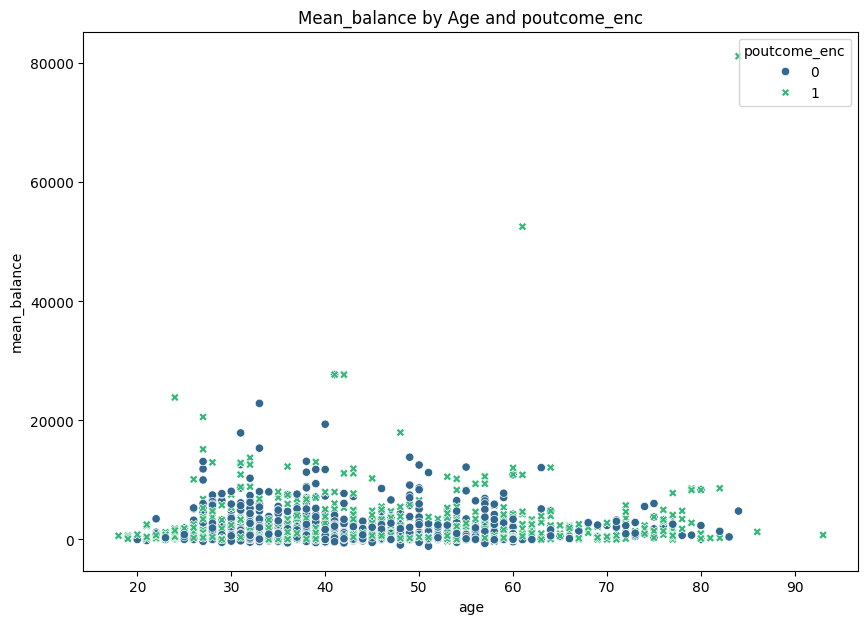

In [11]:
# visualizations of data from first round of campaign
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of Age versus Fare, colored by Survival
plt.figure(figsize=(10, 7))
sns.scatterplot(data=first_round_clients, x='age', y='mean_balance', hue='poutcome_enc', style='poutcome_enc', palette='viridis')
plt.title('Mean_balance by Age and poutcome_enc')
plt.show()

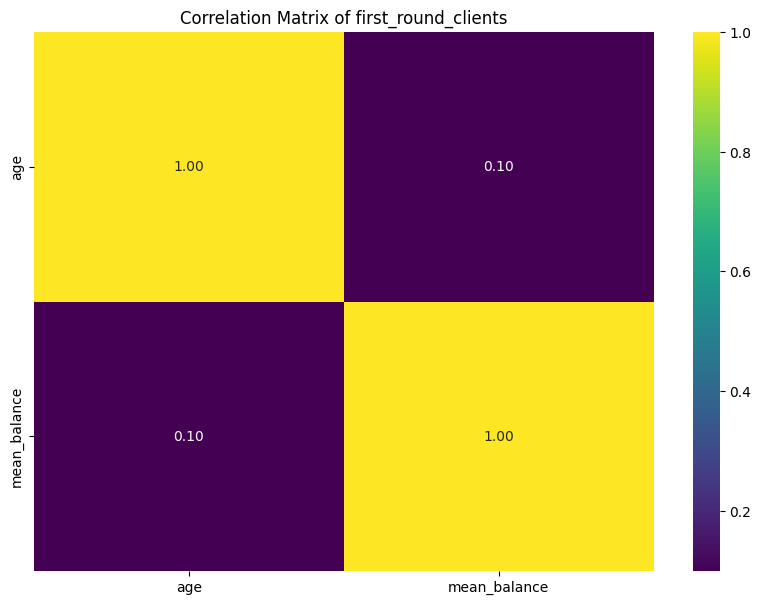

In [12]:
# Calculate the correlation matrix
matrix_data = first_round_clients[["age", "mean_balance"]]
correlation_matrix = matrix_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)
plt.title('Correlation Matrix of first_round_clients')
plt.show()

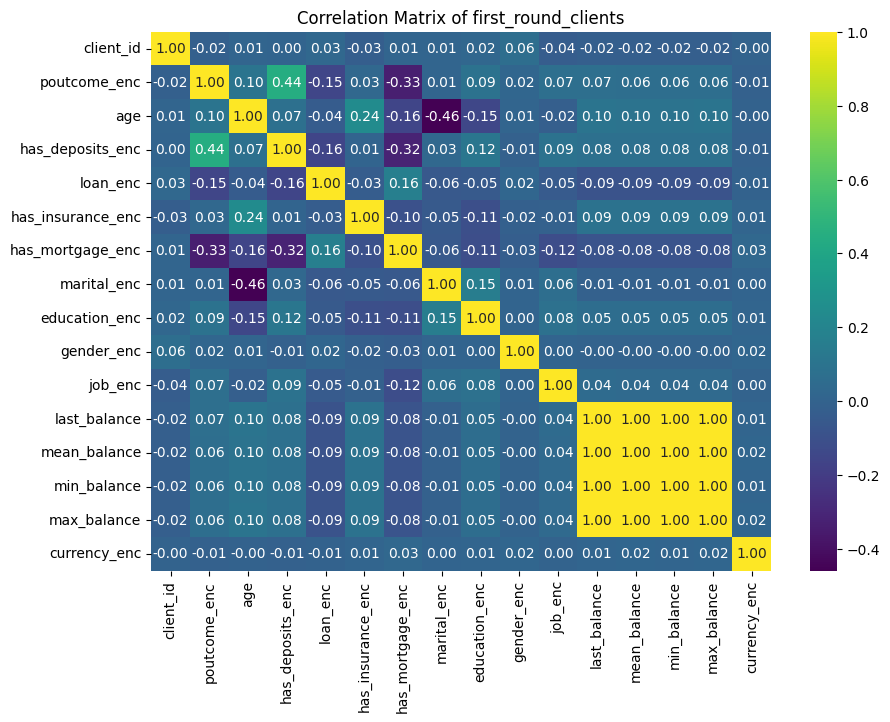

In [13]:
# Calculate the correlation matrix
correlation_matrix = first_round_clients.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)
plt.title('Correlation Matrix of first_round_clients')
plt.show()

In [16]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

features = ['age', 'has_deposits_enc', 'loan_enc',
       'has_insurance_enc', 'has_mortgage_enc', 'marital_enc', 'education_enc',
       'gender_enc', 'job_enc', 'last_balance', 'mean_balance', 'min_balance',
       'max_balance']


X = first_round_clients[features]
y = first_round_clients["poutcome_enc"]


# Spliting table into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
# Show parametry in the X_train
X_train.shape
X_test.shape

(460, 13)

In [19]:
# Specify how it should look my model1. Need to encode!!!
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input


# Specify how it should look my model2. No need to encode
model2 = Sequential([
    # input znamena kolik features mam v inputu. Tzn napriklad kolik sloupcu mam v inputu
    Input(shape = (13,)),
    Dense(32, activation = "tanh"),
    Dense(32, activation = "tanh"),
    Dense(1, activation = "sigmoid")

])

model2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
history = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose = 0)


In [20]:
# Check accuracy of the model2
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

15/15 [==============================] - 0s 7ms/step - loss: 0.6369 - accuracy: 0.6739
Test accuracy: 67.39%


15/15 [==============================] - 0s 3ms/step


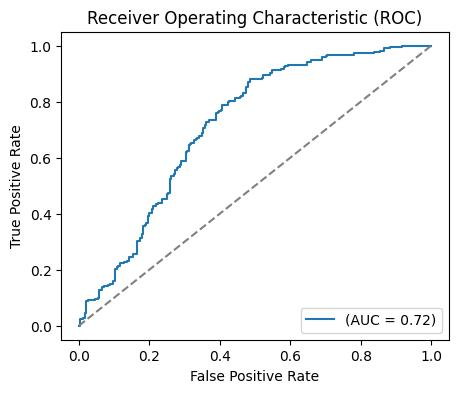

In [21]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, model2.predict(X_test)) #[:,1] for 2D output (model 1)
roc_auc = auc(fpr, tpr)

# plot line
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"(AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error, f1_score

clf = DecisionTreeClassifier(criterion = "gini", max_depth = 3, min_samples_split = 4 )
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.2f}".format(mse))

Mean Squared Error: 0.30


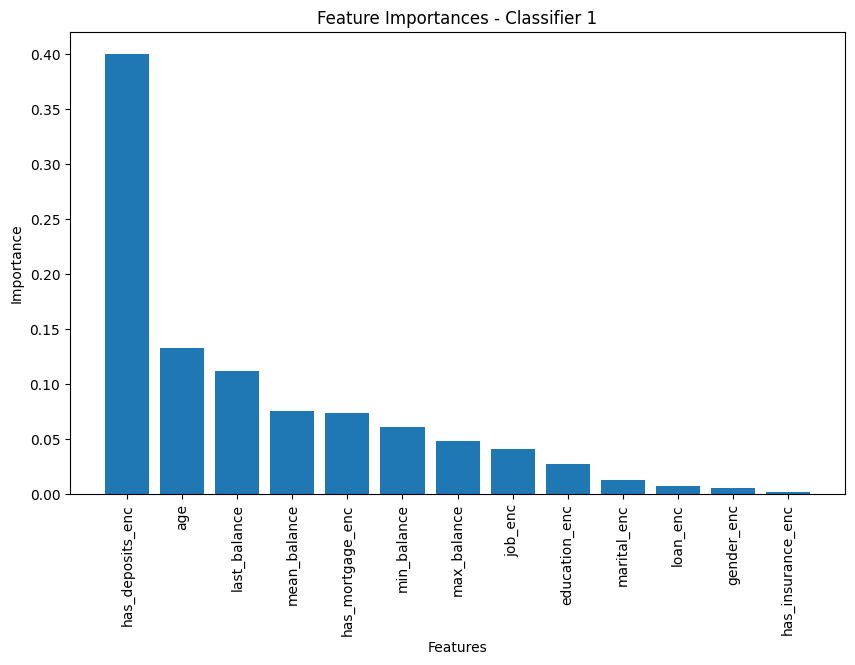

In [69]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# List of classifiers with different hyperparameters
classifiers = [
    # DecisionTreeClassifier(),
    DecisionTreeClassifier(max_depth=13, min_samples_split=13)
    # Add more classifiers with different hyperparameters as needed
]

# Loop through classifiers
for idx, clf in enumerate(classifiers):
    # Fit the classifier
    clf.fit(X_train, y_train)
    
    # Get feature importances
    importances = clf.feature_importances_
    
    # Sort feature importances in descending order
    indices = importances.argsort()[::-1]

    # Get actual feature names
    feature_names = ['age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc',
                     'marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance',
                     'mean_balance', 'min_balance', 'max_balance']

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances - Classifier {idx + 1}")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)  # Use actual feature names as labels
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()


In [74]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

featuress = ['age', 'has_deposits_enc', 'has_mortgage_enc', 
       'job_enc', 'last_balance', 'mean_balance', 'min_balance',
       'max_balance']


X = first_round_clients[featuress]
y = first_round_clients["poutcome_enc"]


# Spliting table into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
# Specify how it should look my model1. Need to encode!!!
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input


# Specify how it should look my model2. No need to encode
model2 = Sequential([
    # input znamena kolik features mam v inputu. Tzn napriklad kolik sloupcu mam v inputu
    Input(shape = (8,)),
    Dense(32, activation = "tanh"),
    Dense(32, activation = "tanh"),
    Dense(1, activation = "sigmoid")

])

model2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
history = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose = 0)


In [76]:
# Check accuracy of the model2
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

15/15 [==============================] - 0s 3ms/step - loss: 0.5930 - accuracy: 0.6891
Test accuracy: 68.91%


In [88]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
import pandas as pd


# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 4)
# rf_classifier = RandomForestClassifier(n_estimators=50, max_depth = 4)

# Fit and evaluate the Random Forest model
model3 = rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)

print("Random Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.2f}")


Random Forest Classifier:
Accuracy: 0.69
